In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import skimage
import skimage.io
from skimage.color import rgb2gray
from sklearn.cluster import KMeans
from scipy import sparse

classes = ["airplane","chair"]

def get_patches(I, dim):
    """
    Given an an MxN single channel image I, get all dimxdim dimensional
    patches
    Parameters
    ----------
    I: ndarray(M, N)
        Single channel image
    dim: int
        Dimension of patches
    Returns
    -------
    P: ndarray((M-dim+1), (N-dim+1), dimxdim))
        Array of flattened patches
    """
    #http://stackoverflow.com/questions/13682604/slicing-a-numpy-image-array-into-blocks
    shape = np.array(I.shape*2)
    strides = np.array(I.strides*2)
    W = np.asarray(dim)
    shape[I.ndim:] = W
    shape[:I.ndim] -= W - 1
    if np.any(shape < 1):
        raise ValueError('Window size %i is too large for image'%dim)
    P = np.lib.stride_tricks.as_strided(I, shape=shape, strides=strides)
    return P


def make_dictionary(K, n_clusters, n):
    """
    Parameters
    ----------
    K: int
        Resolution of patch
    n_clusters: int
        Number of clusters to create
    n: int
        Number of patches per image
    """
    X = np.array([])
    for c in classes:
        print("Loading ", c)
        for i in range(1, 51):
            f = "images/{}/image_{:04d}.jpg".format(c, i)
            I = skimage.io.imread(f)
            I = rgb2gray(I)
            if I.dtype == np.uint8:
                I = np.array(I, dtype=float)/255
            P = get_patches(I, K)
            P = np.reshape(P, (P.shape[0]*P.shape[1], K*K))
            P = P[np.random.permutation(P.shape[0])[0:n], :]
            if X.size == 0:
                X = P
            else:
                X = np.concatenate((X, P), axis=0)
    print("Doing kmeans...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    return kmeans


In [2]:
K = 11
n_clusters = 100
n = 100
kmeans = make_dictionary(K, n_clusters, n)

Loading  airplane
Loading  chair
Doing kmeans...


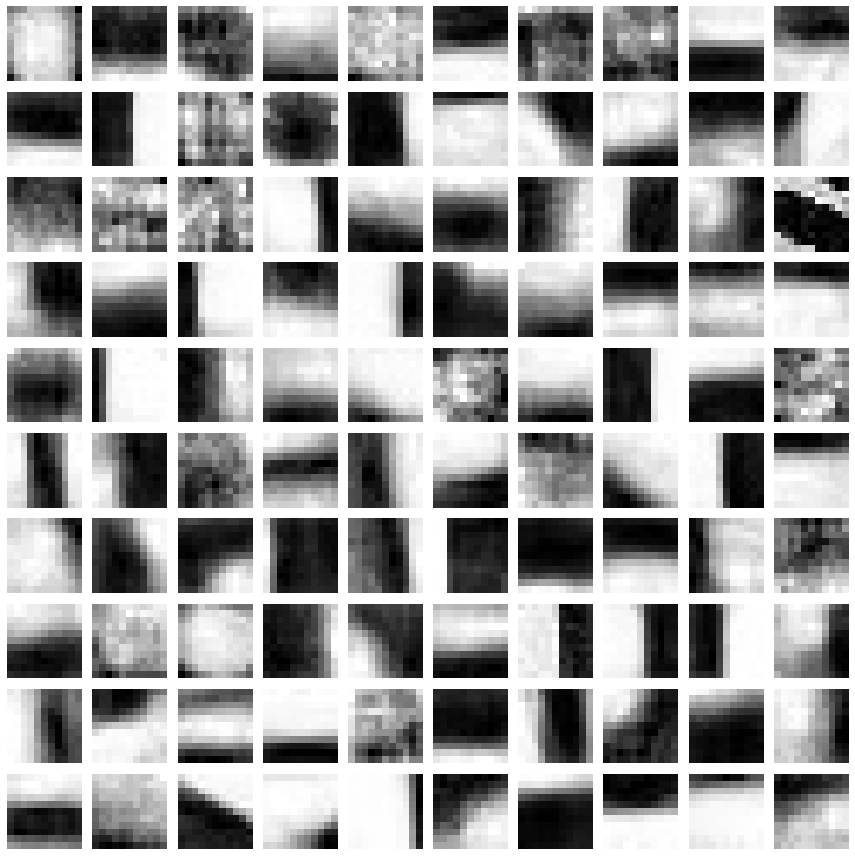

In [3]:
def display_dict_labels(kmeans):
    centers = kmeans.cluster_centers_
    N = centers.shape[0]
    K = int(np.sqrt(centers.shape[1]))
    d = int(np.ceil(np.sqrt(N)))
    plt.figure(figsize=(12, 12))
    for i in range(N):
        plt.subplot(d, d, i+1)
        x = np.reshape(centers[i, :], (K, K))
        plt.imshow(x, cmap='gray')
        plt.axis("off")
    plt.tight_layout()

display_dict_labels(kmeans)

In [4]:
def get_image_bow_histogram(f, kmeans):
    I = skimage.io.imread(f)
    I = rgb2gray(I)
    if I.dtype == np.uint8:
        I = np.array(I, dtype=float)/255
    P = get_patches(I, K)
    P = np.reshape(P, (P.shape[0]*P.shape[1], K*K))
    idx = np.array(kmeans.predict(P), dtype=int)
    s = sparse.coo_matrix((np.ones(idx.size), (np.zeros(idx.size, dtype=int), idx)), shape=(1, n_clusters))
    s = s.toarray().flatten()
    return s

In [5]:
# Now setup model for each class
models = {}
for c in classes:
    print(c)
    models[c] = np.zeros(n_clusters)
    idx = np.array([])
    for i in range(1, 51):
        models[c] += get_image_bow_histogram("images/{}/image_{:04d}.jpg".format(c, i), kmeans)
    # Convert to log Laplace smoothed probabilities
    models[c] = np.log((1 + models[c])/(np.sum(models[c]) + n_clusters))

airplane
chair


In [6]:
confusion = np.zeros((len(classes), len(classes)))
for i, cgt in enumerate(classes):
    print("Classifying ", cgt, "examples")
    for k in range(51, 61):
        hist = get_image_bow_histogram("images/{}/image_{:04d}.jpg".format(c, k), kmeans)
        # Now try to classify this with each model
        likelihoods = np.zeros(len(classes))
        for j, classj in enumerate(classes):
            model = models[classj]
            likelihoods[j] = np.sum(model*hist)
        print(likelihoods, np.argmax(likelihoods), classes[np.argmax(likelihoods)])
        confusion[i, np.argmax(likelihoods)] += 1
            

Classifying  airplane examples
[-235641.16498165 -211220.599361  ] 1 chair
[-355992.56842307 -347456.80589772] 1 chair
[-306688.71533916 -308290.25855374] 0 airplane
[-321540.13595803 -307721.12934459] 1 chair
[-323749.37306019 -307983.26001054] 1 chair
[-285276.32389215 -245878.17775787] 1 chair
[-189623.76691555 -198808.46081357] 0 airplane
[-241932.5157383  -237795.63671344] 1 chair
[-314982.78432841 -305045.42503487] 1 chair
[-244982.05293176 -240040.79087782] 1 chair
Classifying  chair examples
[-235641.16498165 -211220.599361  ] 1 chair
[-355992.56842307 -347456.80589772] 1 chair
[-306688.71533916 -308290.25855374] 0 airplane
[-321540.13595803 -307721.12934459] 1 chair
[-323749.37306019 -307983.26001054] 1 chair
[-285276.32389215 -245878.17775787] 1 chair
[-189623.76691555 -198808.46081357] 0 airplane
[-241932.5157383  -237795.63671344] 1 chair
[-314982.78432841 -305045.42503487] 1 chair
[-244982.05293176 -240040.79087782] 1 chair


In [7]:
print(confusion)

[[2. 8.]
 [2. 8.]]
